In [1]:
# !git clone https://github.com/open-mmlab/mmdetection.git
# !cd mmdetection/ && pip install -e . && cd -

In [34]:
import pandas as pd
from PIL import Image
from tqdm.contrib.concurrent import process_map
from pathlib import Path
import numpy as np
from utils import get_size
import json
import os

# EDA

In [35]:
BBox_df = pd.read_csv('../../data/BBox_List_2017.csv')
print(f'BBox_df dataset len {len(BBox_df)}')
print(f'unique images {BBox_df["Image Index"].nunique()}')

BBox_df dataset len 984
unique images 880


In [36]:
BBox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [37]:
BBox_df['Finding Label'].value_counts()

Finding Label
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: count, dtype: int64

#### Data quit unbalanced, will use corresponding sampler

In [38]:
image2path = {item.name: str(item.resolve()) for item in Path('../../data/raw/').glob('images*/*.png')}
BBox_df['path'] = BBox_df['Image Index'].map(image2path)
img_sizes = process_map(get_size, BBox_df['path'], max_workers=4)
print(f' image size are {set(img_sizes)}')

Python(67524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|          | 0/984 [00:00<?, ?it/s]

 image size are {(1024, 1024)}


#### copy images to single folder

In [39]:
import shutil
os.makedirs('../../data/images1000', exist_ok=True)
for image, path in image2path.items():
    if not os.path.exists(os.path.join('../../data/images1000', image)):
        shutil.copy2(path, os.path.join('../../data/images1000', image))

In [40]:
BBox_df['width'], BBox_df['height'] = zip(*img_sizes)

#### all images of same size

In [41]:
BBox_df.describe()

,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,width,height
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0,984.0,984.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN,1024.0,1024.0
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN,0.0,0.0
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN,1024.0,1024.0
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN,1024.0,1024.0
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN,1024.0,1024.0
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN,1024.0,1024.0
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN,1024.0,1024.0


#### No out of image annotations

In [42]:
BBox_df.groupby('Finding Label')['w'].mean()

Finding Label
Atelectasis     218.960376
Cardiomegaly    479.834344
Effusion        221.624451
Infiltrate      294.044417
Mass            168.686870
Nodule           71.942670
Pneumonia       276.470519
Pneumothorax    198.881123
Name: w, dtype: float64

In [43]:
BBox_df.groupby('Finding Label')['h]'].mean()

Finding Label
Atelectasis     139.110324
Cardiomegaly    381.118611
Effusion        318.007295
Infiltrate      297.393439
Mass            189.838700
Nodule           70.433862
Pneumonia       304.486942
Pneumothorax    246.010444
Name: h], dtype: float64

# Train setup

## folds spit

In [44]:
np.random.seed(42)
image_files_names = BBox_df['Image Index'].unique()
np.random.shuffle(image_files_names)
image_files_names = list(image_files_names)
num_unique_image = len(image_files_names)
NUMBER_OF_FOLDS = 5
image2fold = {}
for fold in range(0, NUMBER_OF_FOLDS - 1):
    image2fold.update({image_files_names.pop(): fold for _ in range(num_unique_image//NUMBER_OF_FOLDS)})
image2fold.update({image: NUMBER_OF_FOLDS - 1 for image in image_files_names})
BBox_df['fold'] = BBox_df['Image Index'].map(image2fold)
print(f'num images pert fold {BBox_df.drop_duplicates("Image Index")["fold"].value_counts()}')
print(f'num annotations pert fold {BBox_df["fold"].value_counts()}')

num images pert fold fold
2    176
0    176
3    176
4    176
1    176
Name: count, dtype: int64
num annotations pert fold fold
2    200
0    199
4    197
3    194
1    194
Name: count, dtype: int64


## add class_id field

In [45]:
sorted(BBox_df['Finding Label'].unique())

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

In [46]:
class_name2class_id = {name: id_+1 for id_, name in enumerate(sorted(BBox_df['Finding Label'].unique()))}
BBox_df['class_id'] = BBox_df['Finding Label'].map(class_name2class_id)

In [47]:
test_df = pd.read_csv('../../data/BBox_List_2017_train.csv')

In [48]:
d = {k: v for k, v in zip(BBox_df['Image Index'], BBox_df['fold'])}

In [49]:
test_d = {k: v for k, v in zip(test_df['Image Index'], test_df['fold'])}

In [50]:
all([d[k] == v for k, v in test_d.items()])

True

In [51]:
BBox_df['class_id'].value_counts()

class_id
1    180
3    153
2    146
4    123
7    120
8     98
5     85
6     79
Name: count, dtype: int64

## image stats

In [108]:
  
image_dir=''
sums = 0 
squares_sums = 0  
num_pixels = 0  
  
# Loop over all images  
for image_name in BBox_df[BBox_df['fold'].isin({0, 1, 2})]['path']:  
    # Open image  
    img = Image.open(os.path.join(image_dir, image_name))  
    # Convert image to numpy array  
    img_array = np.array(img) / 255  # scale pixel values to [0, 1]  
    # Flatten the image array  
    pixels = img_array.reshape(-1)  
    # Update sums and squares sums  
    sums += np.sum(pixels)  
    squares_sums += np.sum(pixels**2)  
    num_pixels += pixels.size  # update total number of pixels  
  
# Calculate mean and standard deviation  
mean = sums / num_pixels  
std = np.sqrt(squares_sums / num_pixels - mean**2 + 1e-7)  # add epsilon to avoid negative under sqrt  
  
print('Mean: ', mean * 255)  
print('Std: ', std * 255)  

Mean:  122.48177883526503
Std:  64.48464218488638


## Draw annoatation

In [52]:
from PIL import Image, ImageDraw  


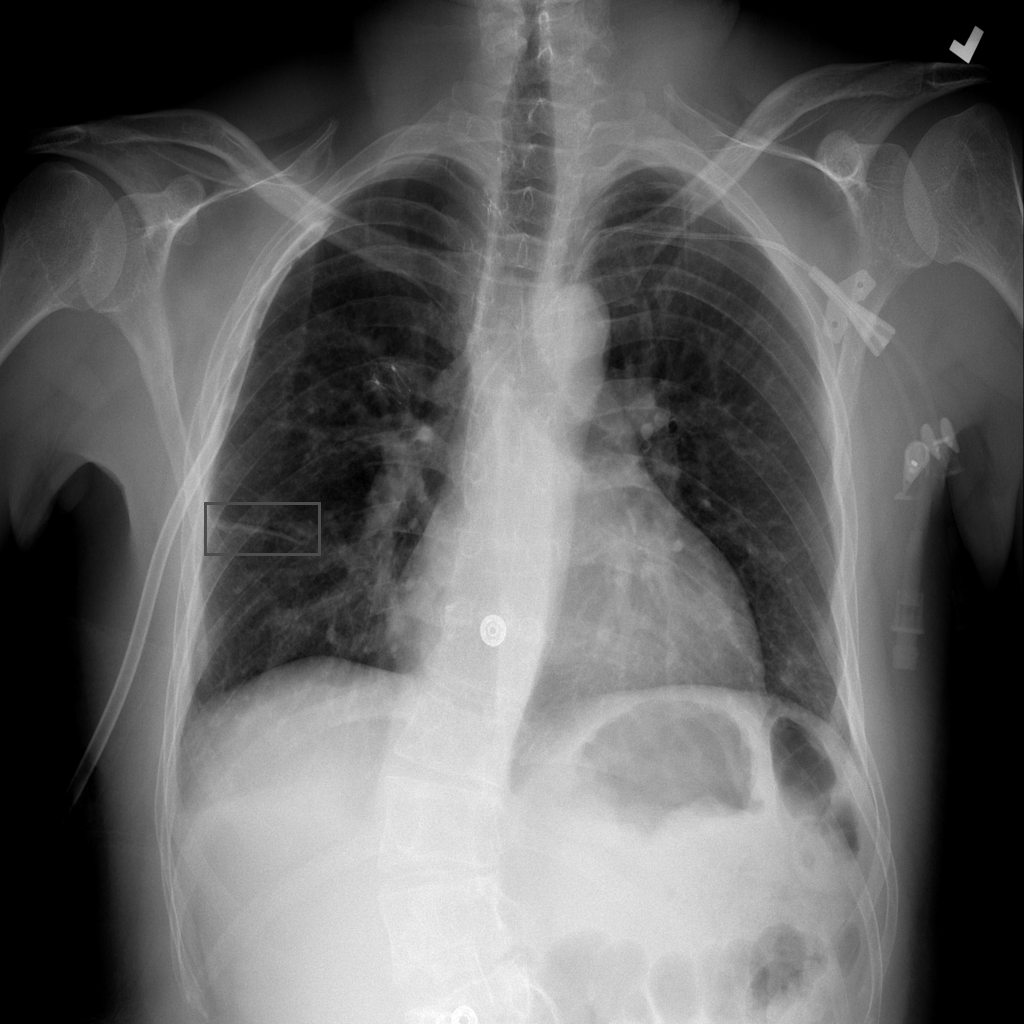

In [53]:
indx= 20
img = Image.open(BBox_df.iloc[indx]['path'])  
draw = ImageDraw.Draw(img)  
  
# Specify the coordinates for the rectangle (top-left and bottom-right corners)  
bbox = BBox_df.iloc[indx][['Bbox [x',	'y',	'w',	'h]']].values
bbox[2:] += bbox[:2]
# Draw the rectangle on the image  
draw.rectangle(list(bbox), outline='red', width=3)
img

In [54]:
BBox_df

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,path,width,height,fold,class_id
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,0,1
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1


In [55]:

BBox_df[BBox_df['fold'].isin({0,1,2})].to_csv('../../data/BBox_List_2017_train.csv')
BBox_df[BBox_df['fold'].isin({3})].to_csv('../../data/BBox_List_2017_val.csv')
BBox_df[BBox_df['fold'].isin({4})].to_csv('../../data/BBox_List_2017_test.csv')

In [56]:
BBox_df.columns

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'path', 'width', 'height', 'fold',
       'class_id'],
      dtype='object')

In [57]:
pd.read_csv('../../data/BBox_List_2017_train.csv')

,Unnamed: 0,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,path,width,height,fold,class_id
0,0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
1,1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,0,1
2,3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
3,4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,0,1
4,8,00014198_000.png,Atelectasis,676.338983,512.307352,98.711864,193.084746,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,977,00020482_032.png,Atelectasis,482.247118,352.900747,210.488889,361.813333,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
589,979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
590,980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1
591,982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,2,1


In [58]:
pd.read_csv('../../data/BBox_List_2017_val.csv')

,Unnamed: 0,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,path,width,height,fold,class_id
0,2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
1,6,00012515_002.png,Atelectasis,289.084746,638.137861,83.525424,56.406780,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
2,7,00022098_006.png,Atelectasis,494.101695,577.392098,271.186441,154.033898,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
3,12,00000808_002.png,Atelectasis,558.101695,384.307352,227.796610,167.050847,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
4,18,00009669_003.png,Atelectasis,157.830508,648.985318,261.423729,220.203390,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,930,00027278_007.png,Pneumothorax,153.870899,47.678307,310.992593,277.401058,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,8
190,935,00025368_033.png,Pneumothorax,759.602116,279.568254,198.298413,193.964021,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,8
191,947,00007471_003.png,Pneumothorax,540.715344,106.192593,333.748148,483.284656,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,8
192,970,00030636_004.png,Atelectasis,611.953785,440.509635,158.151111,151.324444,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,3,1


In [59]:
pd.read_csv('../../data/BBox_List_2017_test.csv')

,Unnamed: 0,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,path,width,height,fold,class_id
0,5,00003148_004.png,Atelectasis,596.067797,505.780787,56.406780,180.067797,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
1,10,00030674_000.png,Atelectasis,632.949153,251.968369,227.796610,210.440678,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
2,23,00030635_001.png,Atelectasis,576.542373,490.612437,240.813559,222.372881,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
3,25,00019124_045.png,Atelectasis,332.474576,520.985318,125.830508,68.338983,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
4,29,00012123_001.png,Atelectasis,639.457627,611.019217,273.355932,215.864407,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,969,00018253_059.png,Atelectasis,185.287118,405.428142,203.662222,287.857778,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
193,972,00012299_002.png,Atelectasis,195.527118,575.905191,658.773333,79.644444,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
194,973,00021703_001.png,Atelectasis,136.362674,500.811858,616.675556,212.764444,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1
195,974,00029464_003.png,Atelectasis,243.313785,374.518524,204.800000,128.568889,NaN,NaN,NaN,/Users/dmitry/Projects/dantiai/data/raw/images...,1024,1024,4,1


## Convert to COCO

In [60]:
import pandas as pd  
import json  
import os  
from PIL import Image  
  
# Load your CSV data  
def convert2coco(df):  
    # Initialize COCO-style dataset  
    coco_data = {  
        "images": [],  
        "annotations": [],  
        "categories": []  
    }  
      
    # Define category  
    # category = {  
    #     "id": 1,  
    #     "name": "your_category_name",  
    #     "supercategory": "none"  
    # }  
    # coco_data["categories"].append(category)  
    processed_ids = set()
    # Process each row in the dataframe  
    for idx, row in df.iterrows():  
        # Get image info  
        # img_path = row['path']  
        # img = Image.open(img_path)  
        width, height = row['width'], row['height']  
      
        # Add image info to "images" field in COCO data  
        image = {  
            "id": idx,  
            "file_name": row['Image Index'],  
            "width": width,  
            "height": height  
        }  
        coco_data["images"].append(image)  
      
        # Add annotation info to "annotations" field in COCO data  
        annotation = {  
            "id": idx,  
            "image_id": idx,  
            "category_id": row['class_id'],  
            "bbox": [row['Bbox [x'], row['y'], row['w'], row['h]']],  
            "area": row['w'] * row['h]'],  
            "iscrowd": 0  
        } 
        if row['class_id'] not in processed_ids:
            processed_ids.add(row['class_id'])
            coco_data["categories"].append({  
                "id": row['class_id'],  
                "name": row["Finding Label"],  
                "supercategory": "none"})
        coco_data["annotations"].append(annotation)  
    return coco_data
    # Save COCO data to a JSON file  
    # with open('coco_data.json', 'w') as f:  
    #     json.dump(coco_data, f)  


In [61]:
!ls ../../data/

BBox_List_2017.csv        BBox_List_2017_train.csv  BBox_List_2017_val.json
BBox_List_2017_test.csv   BBox_List_2017_train.json images1000
BBox_List_2017_test.json  BBox_List_2017_val.csv    raw


Python(67566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [100]:
for path in Path('../../data/').glob('BBox_List_2017_*.csv'):
    df = pd.read_csv(path)
    coco_data = convert2coco(df)
    with open(str(path.with_suffix('.json')), 'w') as f:
        json.dump(coco_data, f)

# Mock dataset to overfitting

In [65]:
_BBox_df = BBox_df.sample(n=16, random_state=42)
_coco_data = convert2coco(_BBox_df)
for path in ('../../test_data/BBox_List_2017_train.csv', '../../test_data/BBox_List_2017_val.csv', '../../test_data/BBox_List_2017_test.csv'):
    with open(str(Path(path).with_suffix('.json')), 'w') as f:
        json.dump(_coco_data, f)
# _BBox_df.to_csv('../../test_data/BBox_List_2017_train.csv')
# _BBox_df.to_csv('../../test_data/BBox_List_2017_val.csv')
# _BBox_df.to_csv('../../test_data/BBox_List_2017_test.csv')

In [25]:
_BBox_df['class_id'].value_counts()

class_id
3    8
1    5
2    4
7    4
8    4
4    3
6    2
5    2
Name: count, dtype: int64

In [66]:
!cat ../../test_data/BBox_List_2017_train.json

{"images": [{"id": 613, "file_name": "00022837_005.png", "width": 1024, "height": 1024}, {"id": 451, "file_name": "00005089_014.png", "width": 1024, "height": 1024}, {"id": 731, "file_name": "00016587_069.png", "width": 1024, "height": 1024}, {"id": 436, "file_name": "00011827_003.png", "width": 1024, "height": 1024}, {"id": 275, "file_name": "00012793_000.png", "width": 1024, "height": 1024}, {"id": 582, "file_name": "00013993_083.png", "width": 1024, "height": 1024}, {"id": 707, "file_name": "00015141_002.png", "width": 1024, "height": 1024}, {"id": 299, "file_name": "00000756_001.png", "width": 1024, "height": 1024}, {"id": 718, "file_name": "00020393_001.png", "width": 1024, "height": 1024}, {"id": 494, "file_name": "00013391_005.png", "width": 1024, "height": 1024}, {"id": 351, "file_name": "00021381_013.png", "width": 1024, "height": 1024}, {"id": 594, "file_name": "00020124_003.png", "width": 1024, "height": 1024}, {"id": 652, "file_name": "00022726_002.png", "width": 1024, "hei

Python(67634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [68]:
_BBox_df['class_id'].nunique()

7